In [1]:
# For timing each cell
!pip install ipython-autotime
%load_ext autotime

time: 2.79 ms (started: 2021-03-29 21:29:39 +00:00)


In [2]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load word processing libraries
import re
import unicodedata
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from wordcloud import WordCloud

# Load ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, mean_squared_error
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import LinearSVC
# from sklearn.ensemble import RandomForestClassifier
try:
    from xgboost import XGBClassifier, XGBRegressor
except:
    !pip install xgboost
    from xgboost import XGBClassifier, XGBRegressor

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
time: 3.95 s (started: 2021-03-29 21:29:39 +00:00)


In [3]:
# Load in train data
train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.drop(columns=['reviewTime', 'unixReviewTime', 'reviewHash', 'image'], inplace=True)
train_df.head()

(150000, 11)


,overall,reviewerID,reviewText,summary,category,price,itemID
0,5.0,u92990698,A contemporary jazz and soul performer who's m...,""" CLASSIQUE """,Jazz,$8.40,p23649501
1,5.0,u36200649,Very good idea to put both the 'pop' and 'orch...,Exceeded my Expectations - This album RAWKS!,Alternative Rock,$10.98,p58458313
2,5.0,u10721702,This is a great collection of Carole King's so...,A Must-have for Carole King Fans,Pop,$5.99,p97027626
3,5.0,u86003775,The is album is a brilliant piece of Jazz fusi...,A Master piece!,Jazz,$14.64,p43167086
4,5.0,u25672859,Waited a LONG time for this DVD to be released...,especially if you like concert videos,Alternative Rock,$9.92,p94494236


time: 1.92 s (started: 2021-03-29 21:29:43 +00:00)


In [4]:
# Load in test data
test_df = pd.read_csv('test.csv')
print(test_df.shape)
test_df.drop(columns=['reviewTime', 'unixReviewTime', 'reviewHash', 'image'], inplace=True)
test_df.head()

(20000, 10)


,reviewerID,reviewText,summary,category,price,itemID
0,u04140621,ok,Five Stars,Pop,$31.20,p65721979
1,u74766187,The 1955 and 1958 sets alone are worth the pur...,Buy It For the 1955 Set With Monk!,Jazz,$34.04,p87809670
2,u31689638,Mary J Blige is someone most people know of. S...,Mary's excellent debut! Classic!,Pop,$1.72,p52702240
3,u35613516,Very good satch album,Four Stars,Pop,$10.99,p01314374
4,u93320378,Well there are hundreds of Christmas anthologi...,CD lives up to its name,Alternative Rock,$7.98,p84396269


time: 275 ms (started: 2021-03-29 21:29:45 +00:00)


In [5]:
# Using NLTK's list of stopwords
stopword_list = stopwords.words('english')
print(stopword_list)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [6]:
# Change column data types
train_df.reviewText = train_df.reviewText.astype('string')
train_df.summary = train_df.summary.astype('string')
train_df.price = train_df.price.astype('string')
train_df.overall = train_df.overall.astype('float')

test_df.reviewText = test_df.reviewText.astype('string')
test_df.summary = test_df.summary.astype('string')
test_df.price = test_df.price.astype('string')

time: 245 ms (started: 2021-03-29 21:29:45 +00:00)


In [7]:
# Create function for cleaning the tweets column
def clean_text(s):
    # Make sure all characters are in lowercase
    try:
        s = s.lower()
    except:
        s = ''
    # Remove HTML tags and attributes from the string
    # s = BeautifulSoup(s,'lxml').get_text() # takes longer
    html_tags = re.compile('<.*?>')
    s = re.sub(html_tags, '', s)
    # Replace HTML character codes with ASCII equivalent
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('utf-8')
    # Remove URLs
    s = re.sub(r'http\S+', '', s)
    # Remove mentions
    s = re.sub("@[A-Za-z0-9]+", "", s)
    # Remove new line and line breaks characters
    s = s.replace('b"', '').replace("b'", '').replace('\n', '').replace('\\n', '').replace('\\n\\n', '').replace('\t', '')
    # Replace non-letters and extra white spaces with one space
    non_letters = re.compile('[^a-zA-Z]+')
    s = non_letters.sub(' ', s)
    # Remove retweet letters
    s = re.sub(r'\brt\b', '', s)
    # Lemmatization
    s = lemmatizer.lemmatize(s)
    # Remove stop words
    text_tokens = word_tokenize(s)
    s = [word for word in text_tokens if not word in stopword_list]
    # Remove words with only 1 letters
    s = [i for i in s if len(i) > 1]
    if not s:
        return []
    return s

time: 25.5 ms (started: 2021-03-29 21:29:45 +00:00)


In [8]:
# Clean price column
def clean_price(s):
    s = s.replace('$', '')
    try:
        s = float(s)
    except:
        s = np.nan
    if s == '':
        s = np.nan
    return s

time: 4.31 ms (started: 2021-03-29 21:29:45 +00:00)


In [9]:
# Clean train set text features
train_df.reviewText = train_df.reviewText.apply(clean_text)
train_df.reviewText = train_df.reviewText.apply(' '.join)
train_df.summary = train_df.summary.apply(clean_text)
train_df.summary = train_df.summary.apply(' '.join)
train_df.price = train_df.price.apply(clean_price)
pd.set_option('display.max_colwidth', None)
train_df.head()

,overall,reviewerID,reviewText,summary,category,price,itemID
0,5.0,u92990698,contemporary jazz soul performer made two decade career effortlessly composing interpreting smooth sensual music downing one consummate artists capable singing tax code transforming baby generating smash practically brainer collection classique allows imagine soul hits musical titans david ruffin barry white originals well present compositions long time collaborator rex rideout top bottom classique embodies come expect years mr downing buttery baritone miraculously unaffected debilitating bout muscle disorder polymyositis poured billowy ballads mellow mid tempos soothe seduce trademark tender touch pulls listener ride intro breathless invitation paradise stop valentine pledging devotion affection beloved undulating time tic toc plea another chance ignite flames midst busy lives obligations smoldering think wants pick long ago love left one inspired cuts mid tempo something special shimmers sweetness newfound attraction could resist man willing take orders implores love suggestions song stylist sherrida whatever menu serve baby coos soup ladies reason reinterpreted tracks starts stumble bit baby real brings back doo wop sugary sweetness originals brought song david ruffin hit statue fool still emotive original version gon na love little baby sluggish sexy downfall beyond classique vary textures tones much effort tonight provides overall effect day chocolate binge sweetness welcomed first starts become cloying redundant end full bodied flavorful tonight mean fans overlook outright disregard classique mr downing still demonstrates spades endured since prince sophisticated soul winning formula still formula tweaking ingredients awhile lessen quality timelessness results,classique,Jazz,8.40,p23649501
1,5.0,u36200649,good idea put pop orchestral music matrix reloaded onto one disc personally prefer nd disc orchestral main themes enhanced plus new ones sound positively earth shattered course love song sleeping awake great tune stick mind long time come album whetted appetite see movie hail matrix reloaded,exceeded expectations album rawks,Alternative Rock,10.98,p58458313
2,5.0,u10721702,great collection carole king songs,must carole king fans,Pop,5.99,p97027626
3,5.0,u86003775,album brilliant piece jazz fusion start finish person gave album star rating said production lacking far truth wondering perhaps cheap system listened faulty headphones every bit good come shade better every song including two vocal scatting songs opinion gems brilliant album let moments time stars way,master piece,Jazz,14.64,p43167086
4,5.0,u25672859,waited long time dvd released watching year old vhs dieing slow death top favorites list since joshua tree concert way back beginning heard college radio captures group younger men performed simple honest passion energy see someone gave tickets would give almost anything seen back concert one ages reviewers complained video quality keep mind recorded days vhs anomalies light trails camera moves across spotlight slightly grainy right top screen keep mind rainy foggy show said watchable especially like concert videos editing flows well audio pretty good cd concert reissue old blood red sky cd,especially like concert videos,Alternative Rock,9.92,p94494236


time: 2min 31s (started: 2021-03-29 21:29:45 +00:00)


In [10]:
# Clean test set text features
test_df.reviewText = test_df.reviewText.apply(clean_text)
test_df.reviewText = test_df.reviewText.apply(' '.join)
test_df.summary = test_df.summary.apply(clean_text)
test_df.summary = test_df.summary.apply(' '.join)
test_df.price = test_df.price.apply(clean_price)
pd.set_option('display.max_colwidth', None)
test_df.head()

,reviewerID,reviewText,summary,category,price,itemID
0,u04140621,ok,five stars,Pop,31.20,p65721979
1,u74766187,sets alone worth purchase cost everything else gravy,buy set monk,Jazz,34.04,p87809670
2,u31689638,mary blige someone people know first appeared classic debut whats mary combined gritty soul hip hop beats flowed effortlessly voice almost seemed born sing songs say puffy hell job follow life think puffy lazy sampling neccesary anyways back mary everyone pretty much knows half cd got much radio play sexy reminisce funky real love jazzy love limit remind chaka rufus remake sweet thing standouts love anything also good tracks basically every song excellent mary put heart signature street swagger sweet singing,mary excellent debut classic,Pop,1.72,p52702240
3,u35613516,good satch album,four stars,Pop,10.99,p01314374
4,u93320378,well hundreds christmas anthologies one best ever mix classic songs obscure tunes rock hits favorites recognize make say great mix big ones go get many compilations good bang buck,cd lives name,Alternative Rock,7.98,p84396269


time: 22.1 s (started: 2021-03-29 21:32:17 +00:00)


In [11]:
# train_df.price.fillna(train_df.price.mean(), inplace=True)
# # test_df.price.fillna(test_df.price.mean(), inplace=True)

# train_df.reviewText.replace('', np.nan, inplace=True)
# train_df.summary.replace('', np.nan, inplace=True)
# # test_df.reviewText.replace('', np.nan, inplace=True)
# # test_df.summary.replace('', np.nan, inplace=True)

# train_df.dropna(inplace=True)
# test_df.dropna(inplace=True)

print(train_df.shape)
print(test_df.shape)

(150000, 7)
(20000, 6)
time: 5.6 ms (started: 2021-03-29 21:32:39 +00:00)


In [12]:
# is_NaN = test_df.isnull()
# row_has_NaN = is_NaN.any(axis=1)
# test_df[row_has_NaN]

time: 1.12 ms (started: 2021-03-29 21:32:39 +00:00)


In [13]:
# train_df.category.value_counts()

time: 1.41 ms (started: 2021-03-29 21:32:39 +00:00)


In [14]:
# test_df.category.value_counts()

time: 953 µs (started: 2021-03-29 21:32:39 +00:00)


In [15]:
# cat_encode = {'Pop': 1,
#               'Alternative Rock': 2,
#               'Jazz': 3,
#               'Classical': 4,
#               'Dance & Electronic': 5}
# train_df.category = train_df.category.map(cat_encode)
# test_df.category = test_df.category.map(cat_encode)

# train_df = pd.get_dummies(train_df, columns=['category'], prefix='', prefix_sep='')
# test_df = pd.get_dummies(test_df, columns=['category'], prefix='', prefix_sep='')

time: 2.17 ms (started: 2021-03-29 21:32:39 +00:00)


In [16]:
# train_df.price = StandardScaler().fit_transform(train_df[['price']])
# test_df.price = StandardScaler().fit_transform(test_df[['price']])

time: 1.06 ms (started: 2021-03-29 21:32:39 +00:00)


In [17]:
# # Tokenize
# train_df.reviewText = train_df.reviewText.apply(word_tokenize)
# train_df.summary = train_df.summary.apply(word_tokenize)
# test_df.reviewText = test_df.reviewText.apply(word_tokenize)
# test_df.summary = test_df.summary.apply(word_tokenize)

time: 1.66 ms (started: 2021-03-29 21:32:39 +00:00)


In [18]:
# Create ID pairs
train_df['ID'] = train_df[['reviewerID', 'itemID']].agg('-'.join, axis=1)
train_df.drop(columns=['reviewerID', 'itemID'], inplace=True)
train_df.set_index('ID', inplace=True)
train_df.head()

,overall,reviewText,summary,category,price
ID,,,,,
u92990698-p23649501,5.0,contemporary jazz soul performer made two decade career effortlessly composing interpreting smooth sensual music downing one consummate artists capable singing tax code transforming baby generating smash practically brainer collection classique allows imagine soul hits musical titans david ruffin barry white originals well present compositions long time collaborator rex rideout top bottom classique embodies come expect years mr downing buttery baritone miraculously unaffected debilitating bout muscle disorder polymyositis poured billowy ballads mellow mid tempos soothe seduce trademark tender touch pulls listener ride intro breathless invitation paradise stop valentine pledging devotion affection beloved undulating time tic toc plea another chance ignite flames midst busy lives obligations smoldering think wants pick long ago love left one inspired cuts mid tempo something special shimmers sweetness newfound attraction could resist man willing take orders implores love suggestions song stylist sherrida whatever menu serve baby coos soup ladies reason reinterpreted tracks starts stumble bit baby real brings back doo wop sugary sweetness originals brought song david ruffin hit statue fool still emotive original version gon na love little baby sluggish sexy downfall beyond classique vary textures tones much effort tonight provides overall effect day chocolate binge sweetness welcomed first starts become cloying redundant end full bodied flavorful tonight mean fans overlook outright disregard classique mr downing still demonstrates spades endured since prince sophisticated soul winning formula still formula tweaking ingredients awhile lessen quality timelessness results,classique,Jazz,8.40
u36200649-p58458313,5.0,good idea put pop orchestral music matrix reloaded onto one disc personally prefer nd disc orchestral main themes enhanced plus new ones sound positively earth shattered course love song sleeping awake great tune stick mind long time come album whetted appetite see movie hail matrix reloaded,exceeded expectations album rawks,Alternative Rock,10.98
u10721702-p97027626,5.0,great collection carole king songs,must carole king fans,Pop,5.99
u86003775-p43167086,5.0,album brilliant piece jazz fusion start finish person gave album star rating said production lacking far truth wondering perhaps cheap system listened faulty headphones every bit good come shade better every song including two vocal scatting songs opinion gems brilliant album let moments time stars way,master piece,Jazz,14.64
u25672859-p94494236,5.0,waited long time dvd released watching year old vhs dieing slow death top favorites list since joshua tree concert way back beginning heard college radio captures group younger men performed simple honest passion energy see someone gave tickets would give almost anything seen back concert one ages reviewers complained video quality keep mind recorded days vhs anomalies light trails camera moves across spotlight slightly grainy right top screen keep mind rainy foggy show said watchable especially like concert videos editing flows well audio pretty good cd concert reissue old blood red sky cd,especially like concert videos,Alternative Rock,9.92


time: 8.2 s (started: 2021-03-29 21:32:39 +00:00)


In [19]:
# Create ID pairs
test_df['ID'] = test_df[['reviewerID', 'itemID']].agg('-'.join, axis=1)
test_df.drop(columns=['reviewerID', 'itemID'], inplace=True)
test_df.set_index('ID', inplace=True)
test_df.head()

,reviewText,summary,category,price
ID,,,,
u04140621-p65721979,ok,five stars,Pop,31.20
u74766187-p87809670,sets alone worth purchase cost everything else gravy,buy set monk,Jazz,34.04
u31689638-p52702240,mary blige someone people know first appeared classic debut whats mary combined gritty soul hip hop beats flowed effortlessly voice almost seemed born sing songs say puffy hell job follow life think puffy lazy sampling neccesary anyways back mary everyone pretty much knows half cd got much radio play sexy reminisce funky real love jazzy love limit remind chaka rufus remake sweet thing standouts love anything also good tracks basically every song excellent mary put heart signature street swagger sweet singing,mary excellent debut classic,Pop,1.72
u35613516-p01314374,good satch album,four stars,Pop,10.99
u93320378-p84396269,well hundreds christmas anthologies one best ever mix classic songs obscure tunes rock hits favorites recognize make say great mix big ones go get many compilations good bang buck,cd lives name,Alternative Rock,7.98


time: 971 ms (started: 2021-03-29 21:32:48 +00:00)


In [20]:
# Class counts
train_df.overall.value_counts()

5.0    98213
4.0    29648
3.0    12154
2.0     5213
1.0     4772
Name: overall, dtype: int64

time: 14.2 ms (started: 2021-03-29 21:32:49 +00:00)


In [21]:
# Prepare X and y
train_copy = train_df.copy(deep=True)
X = train_copy.reviewText
y = train_copy.overall

# # Other features
# X2 = train_copy.summary
# # X3 = train_copy[['price', 'Alternative Rock', 'Classical', 'Dance & Electronic', 'Jazz', 'Pop']]
# X = pd.concat([X1, X2], axis=1)
# from scipy.sparse import hstack
# X = hstack((X1, X2))

time: 14.2 ms (started: 2021-03-29 21:32:49 +00:00)


Class=5, n=98213 (65.475%)
Class=1, n=4772 (3.181%)
Class=4, n=29648 (19.765%)
Class=2, n=5213 (3.475%)
Class=3, n=12154 (8.103%)


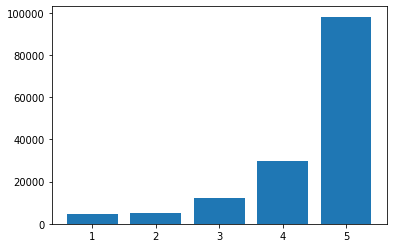

time: 275 ms (started: 2021-03-29 21:32:49 +00:00)


In [22]:
from collections import Counter

counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

plt.bar(counter.keys(), counter.values())
plt.show()

In [23]:
# # SMOTE resampling
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(random_state=1)
# X_sm, y_sm = sm.fit_resample(X, y)

time: 1.41 ms (started: 2021-03-29 21:32:49 +00:00)


In [24]:
# counter = Counter(y_sm)
# for k,v in counter.items():
# 	per = v / len(y_sm) * 100
# 	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# plt.bar(counter.keys(), counter.values())
# plt.show() 

time: 2.41 ms (started: 2021-03-29 21:32:49 +00:00)


In [38]:
# Vectorize X features
tfidf = TfidfVectorizer(max_features=15000, analyzer='word', token_pattern=r'\w+',
                        stop_words='english', ngram_range=(1, 2))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
# eval_set = [(X_test, y_test)]

time: 50.2 s (started: 2021-03-29 21:56:28 +00:00)


In [26]:
# MLP Regressor
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(activation='relu',
                   random_state=1,
                   alpha=0.848,
                   learning_rate_init=0.001,
                   learning_rate='adaptive',
                   max_iter=5000,
                   batch_size=1024,
                   early_stopping=True,
                   validation_fraction=0.1).fit(X_train, y_train)

y_train_pred = mlp.predict(X_train)
print(f'Train MSE: {mean_squared_error(y_train, y_train_pred)}')

y_pred = mlp.predict(X_test)
print(f'Validation MSE: {mean_squared_error(y_test, y_pred)}')

Train MSE: 0.4394817379335679
Validation MSE: 0.5475343267805137
time: 9min 46s (started: 2021-03-29 21:33:39 +00:00)


In [91]:
label_count = y_test.value_counts().rename_axis('unique_values').reset_index(name='counts')
label_count.set_index('unique_values', inplace=True)
label_count

,counts
unique_values,
5.0,19643
4.0,5929
3.0,2431
2.0,1043
1.0,954


time: 27 ms (started: 2021-03-29 23:01:41 +00:00)


In [89]:
y_pred = np.ceil(y_pred)
y_pred = pd.DataFrame({'pred': y_pred}, index=y_test.index)
pred_count = y_pred.value_counts().rename_axis('unique_values').reset_index(name='counts')
pred_count.loc[pred_count['unique_values'] < 1.0, 'unique_values'] = 1.0
pred_count.at[5, 'counts'] = 63 + 9 + 2
pred_count.at[3, 'unique_values'] = 2.0
pred_count.at[4, 'unique_values'] = 1.0
pred_count.at[4, 'counts'] = 289 + 74
pred_count.drop(pred_count.tail(3).index,inplace=True)
pred_count.set_index('unique_values', inplace=True)
pred_count

,unique_values,counts
0,5.0,23337
1,4.0,4308
2,3.0,1036
3,2.0,956
4,1.0,363


time: 28.6 ms (started: 2021-03-29 23:00:53 +00:00)


In [94]:
output_df = pd.concat([label_count, pred_count], axis=1)
output_df.columns = ['label_count', 'pred_count']
output_df

,label_count,pred_count
unique_values,,
5.0,19643,23337
4.0,5929,4308
3.0,2431,1036
2.0,1043,956
1.0,954,363


time: 22.4 ms (started: 2021-03-29 23:03:19 +00:00)


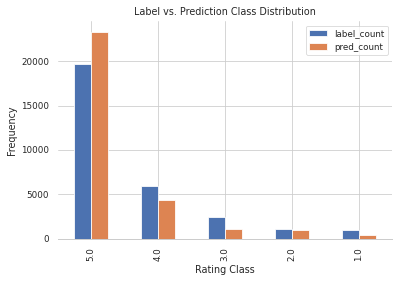

time: 247 ms (started: 2021-03-29 23:26:49 +00:00)


In [102]:
# Plot model output vs. validation labels
sns.set_theme(style="whitegrid")
sns.set_context("paper")
ax = output_df.plot(kind='bar')
ax.set_xlabel('Rating Class')
ax.set_ylabel('Frequency')
ax.set_title('Label vs. Prediction Class Distribution')
sns.despine(left=True)

In [35]:
# XGB regressor
model = XGBRegressor(learning_rate=0.3,
                     n_estimator=900,
                     max_depth=50,
                     min_child_weight=100,
                     gamma=0.5,
                     reg_lambda=50.0,
                     objective='reg:squarederror',
                     colsample_bytree=1.0,
                     colsample_bylevel=1.0,
                     subsample=1.0,
                     seed=1,
                     n_jobs=-1,
                     early_stopping_rounds=5).fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print(f'Train MSE: {mean_squared_error(y_train, y_train_pred)}')

y_pred = model.predict(X_test)
# y_pred = np.round(y_pred, 0)
print(f'Validation MSE: {mean_squared_error(y_test, y_pred)}')

Train MSE: 0.3867210682075521
Validation MSE: 0.6186515499714811
time: 11min 47s (started: 2021-03-27 21:09:59 +00:00)


In [40]:
# Prepare test pairs
true_test_X = tfidf.transform(test_df.reviewText)

true_pred = mlp.predict(true_test_X)

res = {'userID-itemID': test_df.index, 'prediction': true_pred}

res = pd.DataFrame(res)
res.set_index('userID-itemID', inplace=True)
res.head()
res.to_csv('pair_predict.csv')

time: 2.53 s (started: 2021-03-28 07:49:11 +00:00)
